# 🤖 Titanic Survival Prediction - Model Training

## 📊 Mục tiêu
- Train các baseline models
- So sánh performance của different algorithms
- Implement cross-validation
- Chuẩn bị cho hyperparameter tuning

## 📋 Nội dung
1. **Data Preparation**
2. **Baseline Models Training**
3. **Model Performance Comparison**
4. **Cross-Validation Analysis**
5. **Feature Importance Analysis**
6. **Model Selection**


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Import XGBoost và LightGBM (optional - sẽ skip nếu không có)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost version:", xgb.__version__)
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost không có sẵn - sẽ bỏ qua XGBoost models")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✅ LightGBM version:", lgb.__version__)
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️ LightGBM không có sẵn - sẽ bỏ qua LightGBM models")

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Libraries imported successfully!")
print("🎨 Visualization style set!")


⚠️ XGBoost không có sẵn - sẽ bỏ qua XGBoost models
⚠️ LightGBM không có sẵn - sẽ bỏ qua LightGBM models
📚 Libraries imported successfully!
🎨 Visualization style set!


## 1. 📥 Data Preparation


In [8]:
# Import preprocessing utilities
import sys
sys.path.append('../src')

# Import với error handling để tránh lỗi module không tìm thấy
try:
    from data_preprocessing import load_data, preprocess_data, prepare_features, get_feature_columns
    print("✅ Data preprocessing modules imported successfully!")
except ImportError as e:
    print(f"❌ Error importing data preprocessing: {e}")
    raise

try:
    from models import ModelTrainer, evaluate_model
    print("✅ Model modules imported successfully!")
except ImportError as e:
    print(f"⚠️ Error importing models: {e}")
    print("💡 Có thể do thiếu XGBoost hoặc LightGBM. Sẽ tạo ModelTrainer đơn giản...")
    
    # Tạo ModelTrainer đơn giản nếu không import được
    class SimpleModelTrainer:
        def __init__(self, random_state=42):
            self.random_state = random_state
            self.models = {}
            
        def initialize_models(self):
            from sklearn.linear_model import LogisticRegression
            from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
            from sklearn.svm import SVC
            from sklearn.neighbors import KNeighborsClassifier
            from sklearn.naive_bayes import GaussianNB
            from sklearn.tree import DecisionTreeClassifier
            
            self.models = {
                'Logistic Regression': LogisticRegression(random_state=self.random_state, max_iter=1000),
                'Random Forest': RandomForestClassifier(random_state=self.random_state, n_estimators=100),
                'Gradient Boosting': GradientBoostingClassifier(random_state=self.random_state),
                'SVM': SVC(random_state=self.random_state, probability=True),
                'KNN': KNeighborsClassifier(),
                'Naive Bayes': GaussianNB(),
                'Decision Tree': DecisionTreeClassifier(random_state=self.random_state)
            }
            
        def train_models(self, X_train, y_train, X_test, y_test):
            results = {}
            for name, model in self.models.items():
                print(f"🔄 Training {name}...")
                model.fit(X_train, y_train)
                predictions = model.predict(X_test)
                probabilities = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
                accuracy = accuracy_score(y_test, predictions)
                auc = roc_auc_score(y_test, probabilities) if probabilities is not None else None
                
                results[name] = {
                    'model': model,
                    'predictions': predictions,
                    'probabilities': probabilities,
                    'accuracy': accuracy,
                    'auc': auc
                }
            return results
    
    ModelTrainer = SimpleModelTrainer

try:
    from evaluation import evaluate_classification_model, plot_confusion_matrix, plot_roc_curve, compare_models
    print("✅ Evaluation modules imported successfully!")
except ImportError as e:
    print(f"❌ Error importing evaluation: {e}")
    raise

# Load and preprocess data
print("\n📥 Loading and preprocessing data...")
train_df, test_df = load_data('../data/raw/train.csv', '../data/raw/test.csv')
processed_train_df, processed_test_df, label_encoders = preprocess_data(train_df, test_df)

# Prepare features
feature_columns = get_feature_columns()
X = prepare_features(processed_train_df, feature_columns)
y = processed_train_df['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"📊 Training set shape: {X_train.shape}")
print(f"📊 Test set shape: {X_test.shape}")
print(f"📊 Feature columns: {feature_columns}")

# Display feature info
print(f"\n🔍 Feature Information:")
print(f"Features: {list(X.columns)}")
print(f"Target distribution: {y.value_counts().to_dict()}")


✅ Data preprocessing modules imported successfully!
⚠️ Error importing models: No module named 'xgboost'
💡 Có thể do thiếu XGBoost hoặc LightGBM. Sẽ tạo ModelTrainer đơn giản...
✅ Evaluation modules imported successfully!

📥 Loading and preprocessing data...
📊 Training set shape: (891, 12)
📊 Test set shape: (418, 11)
✅ Data preprocessing completed!
📊 Processed training set shape: (891, 22)
📊 Processed test set shape: (418, 22)
📊 Training set shape: (712, 15)
📊 Test set shape: (179, 15)
📊 Feature columns: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'TitleGroup', 'FamilySize', 'IsAlone', 'FamilySizeGroup', 'CabinDeck', 'HasCabin', 'AgeGroup', 'FareGroup']

🔍 Feature Information:
Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'TitleGroup', 'FamilySize', 'IsAlone', 'FamilySizeGroup', 'CabinDeck', 'HasCabin', 'AgeGroup', 'FareGroup']
Target distribution: {0.0: 549, 1.0: 342}


## 2. 🤖 Baseline Models Training


In [10]:
# Initialize model trainer
trainer = ModelTrainer(random_state=42)
trainer.initialize_models()

# Train all models
results = trainer.train_models(X_train, y_train, X_test, y_test)

# Display results summary
print("\n📊 MODEL PERFORMANCE SUMMARY:")
print("=" * 50)
for name, result in results.items():
    auc_value = f"{result['auc']:.4f}" if result['auc'] is not None else 'N/A'
    print(f"{name:20}: Accuracy = {result['accuracy']:.4f}, AUC = {auc_value}")


🔄 Training Logistic Regression...
🔄 Training Random Forest...
🔄 Training Gradient Boosting...
🔄 Training SVM...
🔄 Training KNN...
🔄 Training Naive Bayes...
🔄 Training Decision Tree...

📊 MODEL PERFORMANCE SUMMARY:
Logistic Regression : Accuracy = 0.8212, AUC = 0.8625
Random Forest       : Accuracy = 0.7654, AUC = 0.8196
Gradient Boosting   : Accuracy = 0.7933, AUC = 0.8001
SVM                 : Accuracy = 0.6536, AUC = 0.6943
KNN                 : Accuracy = 0.7039, AUC = 0.7152
Naive Bayes         : Accuracy = 0.7374, AUC = 0.7900
Decision Tree       : Accuracy = 0.7486, AUC = 0.7150


## 3. 📊 Model Performance Comparison



📊 Evaluating Logistic Regression

📊 Logistic Regression - Model Evaluation
🎯 Accuracy:  0.8212
🎯 Precision: 0.7846
🎯 Recall:    0.7391
🎯 F1-Score:  0.7612
🎯 AUC Score: 0.8625

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86       110
         1.0       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179


🔢 Confusion Matrix:
[[96 14]
 [18 51]]


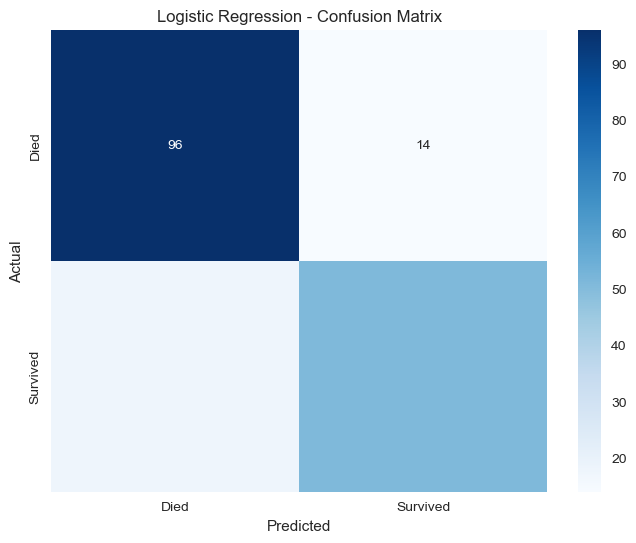

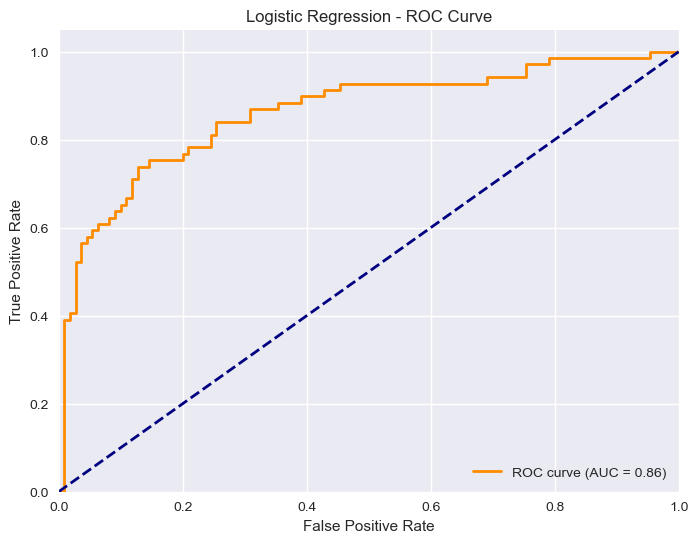


📊 Evaluating Random Forest

📊 Random Forest - Model Evaluation
🎯 Accuracy:  0.7654
🎯 Precision: 0.6800
🎯 Recall:    0.7391
🎯 F1-Score:  0.7083
🎯 AUC Score: 0.8196

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       110
         1.0       0.68      0.74      0.71        69

    accuracy                           0.77       179
   macro avg       0.75      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179


🔢 Confusion Matrix:
[[86 24]
 [18 51]]


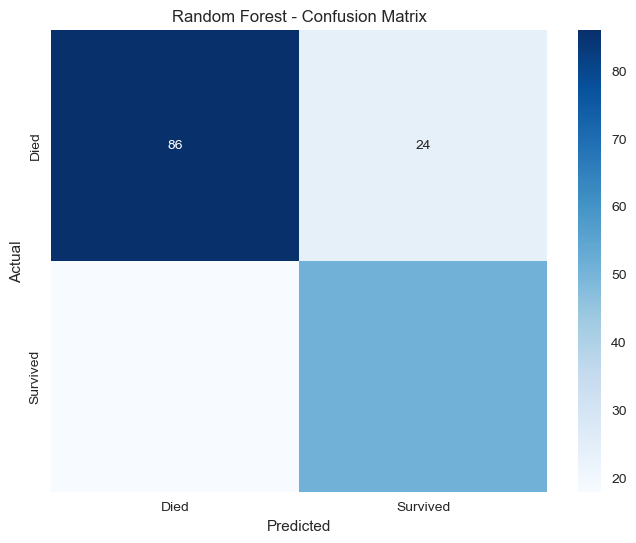

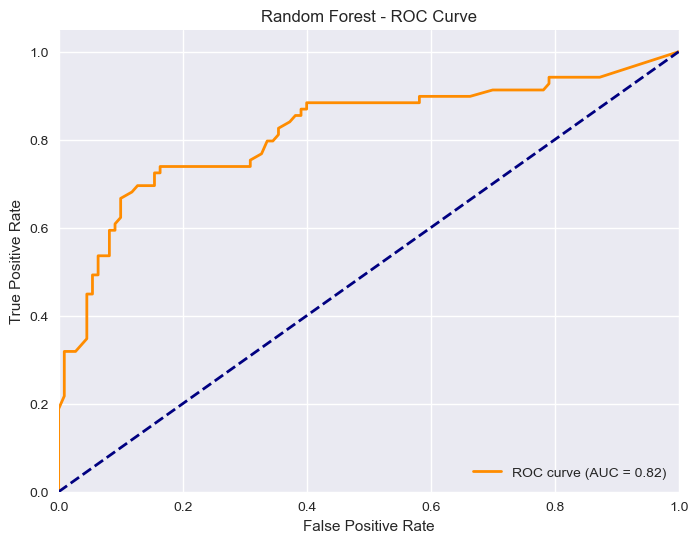


📊 Evaluating Gradient Boosting

📊 Gradient Boosting - Model Evaluation
🎯 Accuracy:  0.7933
🎯 Precision: 0.7857
🎯 Recall:    0.6377
🎯 F1-Score:  0.7040
🎯 AUC Score: 0.8001

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       110
         1.0       0.79      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179


🔢 Confusion Matrix:
[[98 12]
 [25 44]]


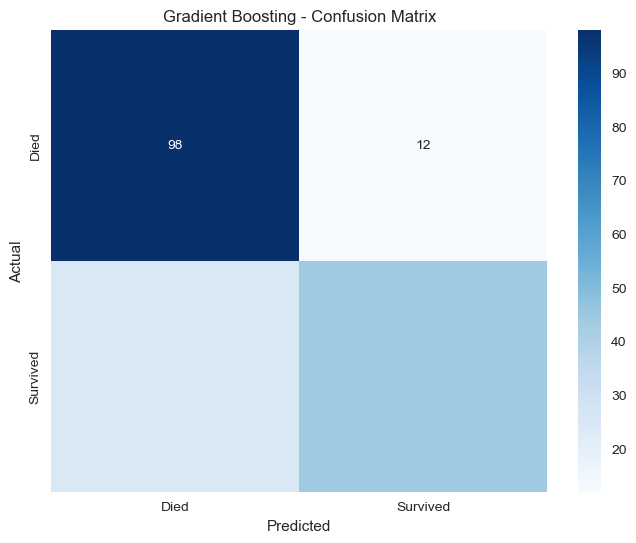

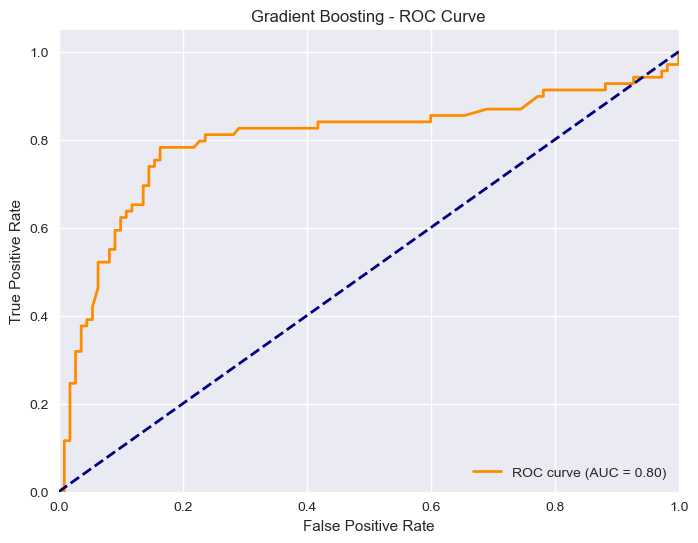


📊 Evaluating SVM

📊 SVM - Model Evaluation
🎯 Accuracy:  0.6536
🎯 Precision: 0.6129
🎯 Recall:    0.2754
🎯 F1-Score:  0.3800
🎯 AUC Score: 0.6943

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.89      0.76       110
         1.0       0.61      0.28      0.38        69

    accuracy                           0.65       179
   macro avg       0.64      0.58      0.57       179
weighted avg       0.64      0.65      0.61       179


🔢 Confusion Matrix:
[[98 12]
 [50 19]]


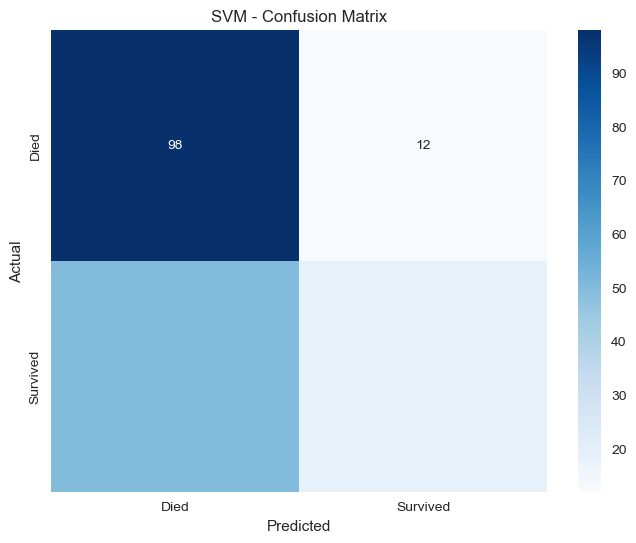

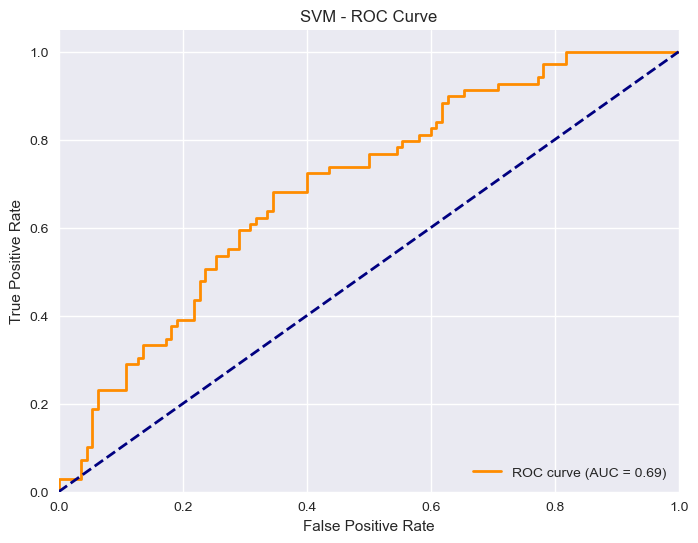


📊 Evaluating KNN

📊 KNN - Model Evaluation
🎯 Accuracy:  0.7039
🎯 Precision: 0.6212
🎯 Recall:    0.5942
🎯 F1-Score:  0.6074
🎯 AUC Score: 0.7152

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76       110
         1.0       0.62      0.59      0.61        69

    accuracy                           0.70       179
   macro avg       0.69      0.68      0.68       179
weighted avg       0.70      0.70      0.70       179


🔢 Confusion Matrix:
[[85 25]
 [28 41]]


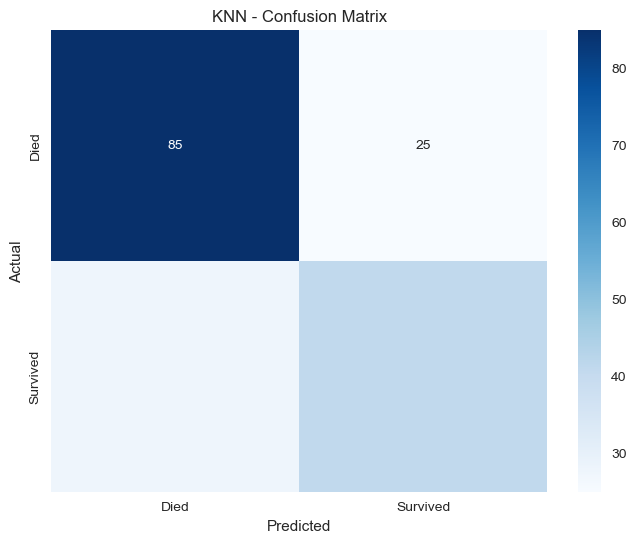

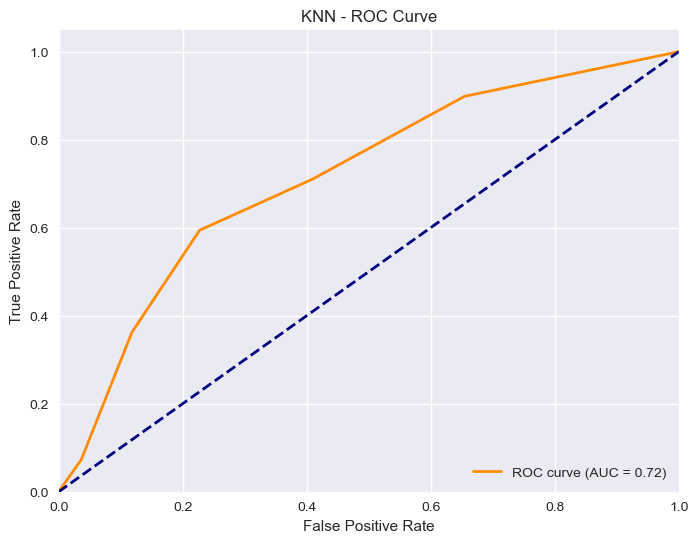


📊 Evaluating Naive Bayes

📊 Naive Bayes - Model Evaluation
🎯 Accuracy:  0.7374
🎯 Precision: 0.6667
🎯 Recall:    0.6377
🎯 F1-Score:  0.6519
🎯 AUC Score: 0.7900

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79       110
         1.0       0.67      0.64      0.65        69

    accuracy                           0.74       179
   macro avg       0.72      0.72      0.72       179
weighted avg       0.74      0.74      0.74       179


🔢 Confusion Matrix:
[[88 22]
 [25 44]]


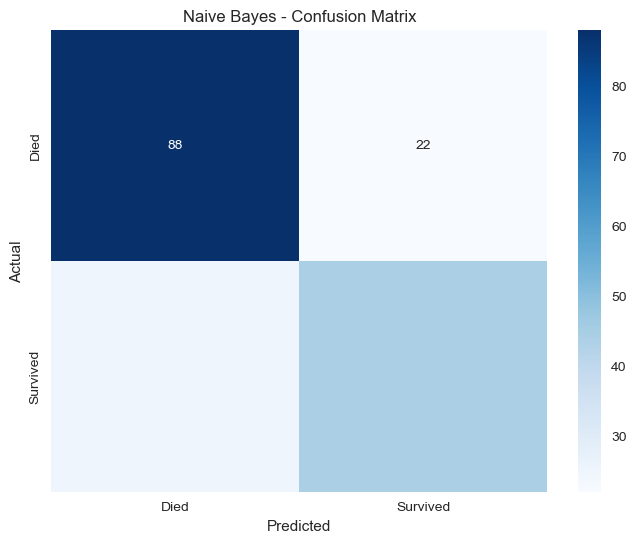

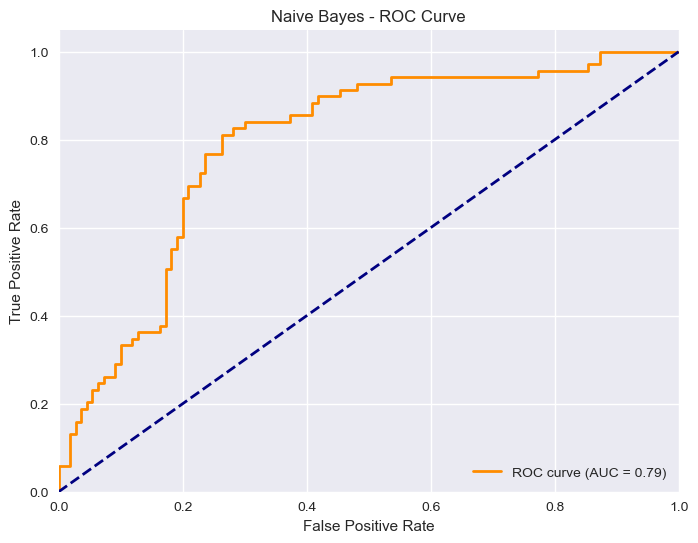


📊 Evaluating Decision Tree

📊 Decision Tree - Model Evaluation
🎯 Accuracy:  0.7486
🎯 Precision: 0.6818
🎯 Recall:    0.6522
🎯 F1-Score:  0.6667
🎯 AUC Score: 0.7150

📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80       110
         1.0       0.68      0.65      0.67        69

    accuracy                           0.75       179
   macro avg       0.73      0.73      0.73       179
weighted avg       0.75      0.75      0.75       179


🔢 Confusion Matrix:
[[89 21]
 [24 45]]


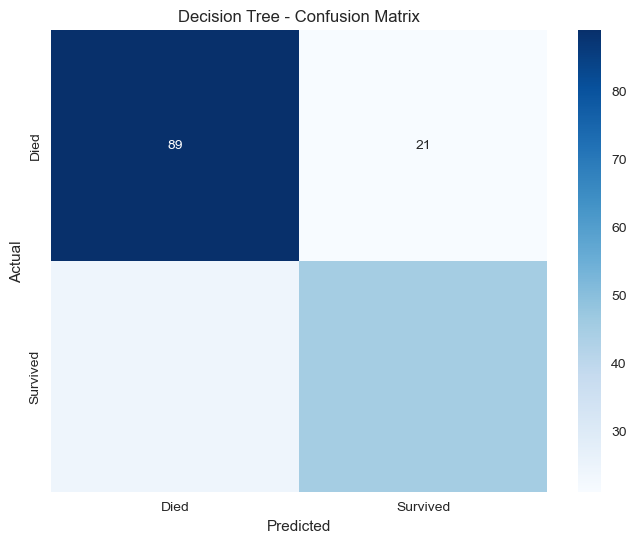

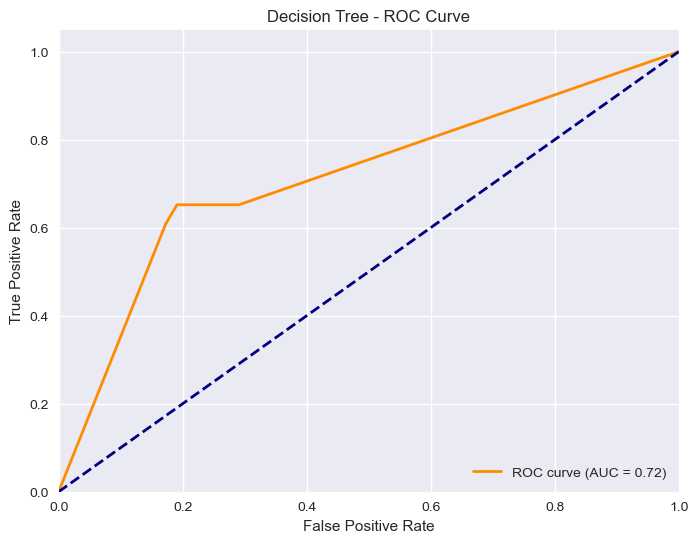


🏆 MODEL COMPARISON:


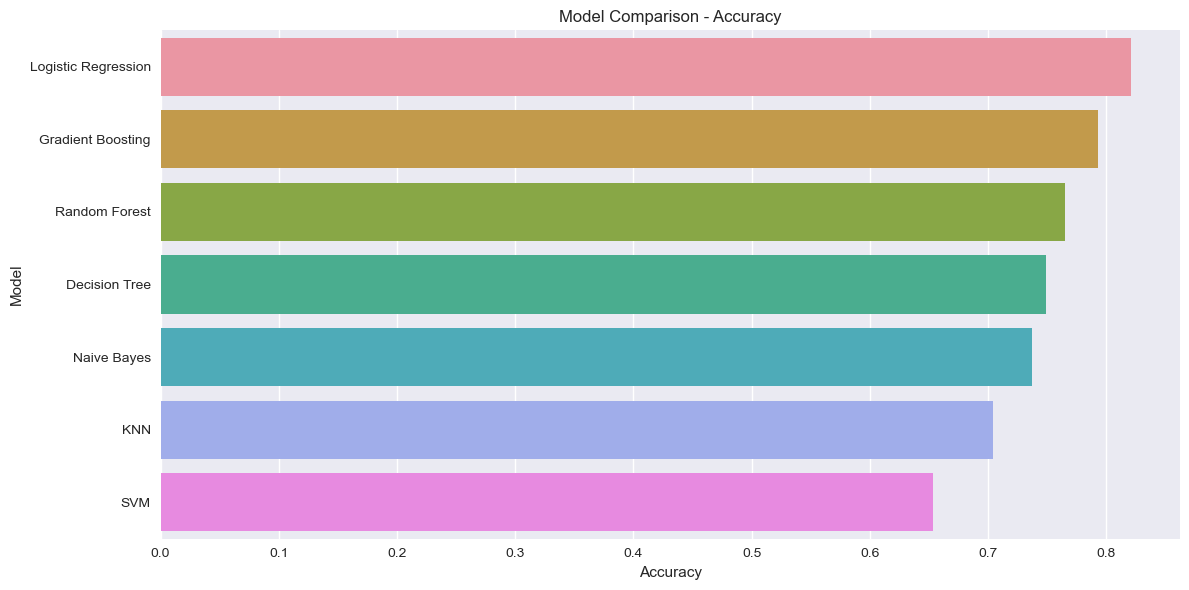


📊 Model Comparison - Accuracy:
Logistic Regression : 0.8212
Gradient Boosting   : 0.7933
Random Forest       : 0.7654
Decision Tree       : 0.7486
Naive Bayes         : 0.7374
KNN                 : 0.7039
SVM                 : 0.6536


In [11]:
# Comprehensive evaluation for each model
evaluation_results = {}

for name, result in results.items():
    print(f"\n{'='*60}")
    print(f"📊 Evaluating {name}")
    print(f"{'='*60}")
    
    # Evaluate model
    eval_result = evaluate_classification_model(
        y_test, result['predictions'], result['probabilities'], name
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, result['predictions'], name)
    
    # Plot ROC curve if probabilities available
    if result['probabilities'] is not None:
        plot_roc_curve(y_test, result['probabilities'], name)
    
    # Store results
    evaluation_results[name] = eval_result

# Compare all models
print("\n🏆 MODEL COMPARISON:")
comparison_df = compare_models(evaluation_results, metric='accuracy')
